In [1]:
import os
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

train_dir = "D:\\Projects\\Mediapipe-RPS\\Rock-Paper-Scissors\\train\\"
test_dir = "D:\\Projects\\Mediapipe-RPS\\Rock-Paper-Scissors\\test\\"
train_path = "D:\\Projects\\Mediapipe-RPS\\train.csv"
test_path = "D:\\Projects\\Mediapipe-RPS\\test.csv"
gesture = ["rock", "paper", "scissors"]

def dataset2images(root_dir, output_path):
    datasets = []
    for i in range(3):
        gesture_dir = os.path.join(root_dir, gesture[i])
        for img_name in tqdm(os.listdir(gesture_dir)):
            img_path = os.path.join(gesture_dir, img_name)
            image = cv2.imread(img_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            landmarks = []
            results = hands.process(image_rgb)
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    for lm in hand_landmarks.landmark:
                        landmarks.append(lm.x)
                        landmarks.append(lm.y)
                        landmarks.append(lm.z)
                    datasets.append(landmarks + [i])
            
    pd.DataFrame(datasets).to_csv(output_path, header=False, index=False)

In [7]:
dataset2images(train_dir, train_path)
dataset2images(test_dir, test_path)

100%|██████████| 124/124 [00:04<00:00, 30.43it/s]


In [16]:
class KeypointsDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.samples = pd.read_csv(data_path).to_numpy()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        keypoints = sample[:-1].astype(np.float32)
        label = sample[-1].astype(np.int64)

        keypoints = self.transform(keypoints) if self.transform else torch.tensor(keypoints, dtype=torch.float32)
        return keypoints, label

def keypoints_transform(keypoints):
    # 1. 将一维数组 (63,) 重塑为 (21, 3) 的矩阵
    kp_matrix = torch.tensor(keypoints, dtype=torch.float32).reshape(21, 3)
    # 2. 获取手腕坐标 (第0行)
    wrist = kp_matrix[0].clone()  # Shape: (3,)
    # 3. 所有点减去手腕坐标 (广播机制，自动应用到每一行)
    kp_matrix -= wrist
    # 4. 归一化 (保持原有逻辑，缩放到 -1 到 1)
    # 注意：这里建议用所有相对坐标的最大值来缩放，保持长宽比
    max_val = torch.max(torch.abs(kp_matrix))
    if max_val > 0:
        kp_matrix /= max_val
    # 5. 展平回 (63,)
    return kp_matrix.flatten()

train_dataset = KeypointsDataset(train_path, transform=keypoints_transform)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataset = KeypointsDataset(test_path, transform=keypoints_transform)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [88]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(63, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 3)
        self.dropout = nn.Dropout(0.6)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [92]:
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [93]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for keypoints, labels in dataloader:
        keypoints, labels = keypoints.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(keypoints)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * keypoints.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for keypoints, labels in dataloader:
            keypoints, labels = keypoints.to(device), labels.to(device)

            outputs = model(keypoints)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * keypoints.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy

Epoch 1/100, Train Loss: 1.0822, Train Acc: 0.3988, Test Loss: 1.0521, Test Acc: 0.3505
Epoch 10/100, Train Loss: 0.2588, Train Acc: 0.9336, Test Loss: 1.3753, Test Acc: 0.6413
Epoch 20/100, Train Loss: 0.0679, Train Acc: 0.9851, Test Loss: 1.2441, Test Acc: 0.6929
Epoch 30/100, Train Loss: 0.0303, Train Acc: 0.9950, Test Loss: 1.1792, Test Acc: 0.7011
Epoch 40/100, Train Loss: 0.0263, Train Acc: 0.9934, Test Loss: 1.0798, Test Acc: 0.7310
Epoch 50/100, Train Loss: 0.0160, Train Acc: 0.9959, Test Loss: 1.0480, Test Acc: 0.7446
Epoch 60/100, Train Loss: 0.0157, Train Acc: 0.9959, Test Loss: 1.2309, Test Acc: 0.7283
Epoch 70/100, Train Loss: 0.0106, Train Acc: 0.9988, Test Loss: 0.9622, Test Acc: 0.7826
Epoch 80/100, Train Loss: 0.0091, Train Acc: 0.9971, Test Loss: 1.0360, Test Acc: 0.7799
Epoch 90/100, Train Loss: 0.0097, Train Acc: 0.9979, Test Loss: 1.0479, Test Acc: 0.7799
Epoch 100/100, Train Loss: 0.0071, Train Acc: 0.9975, Test Loss: 1.0875, Test Acc: 0.7826


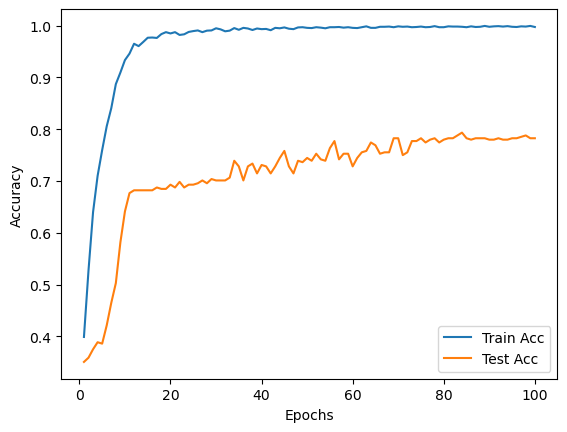

In [94]:
EPOCHS = 100
train_acces = []
test_acces = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_dataloader, criterion, device)
    if test_acc > 0.80:
        print("Achieved over 85% accuracy, stopping training.")
        break

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    train_acces.append(train_acc)
    test_acces.append(test_acc)

plt.plot(range(1, len(train_acces)+1), train_acces, label='Train Acc')
plt.plot(range(1, len(test_acces)+1), test_acces, label='Test Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), "mlp_model_weights.pth")

model = MLP().to(device)
model.load_state_dict(torch.load("mlp_model_weights.pth"))
model.eval()

MLP(
  (fc1): Linear(in_features=63, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (relu): ReLU()
)

In [96]:
# ---------- 加载 PNG ----------
imgs = {
    0: cv2.imread("images\\rock.png", cv2.IMREAD_UNCHANGED),
    1: cv2.imread("images\\paper.png", cv2.IMREAD_UNCHANGED), 
    2: cv2.imread("images\\scissor.png", cv2.IMREAD_UNCHANGED)
}

# ---------- 反手势规则 ----------
opposite = {0: 1, 1: 2, 2: 0}

# ---------- Mediapipe ----------
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)


# ---------- PNG 叠加函数 ----------
def overlay_png(background, png, x, y):
    h, w = png.shape[:2]
    bg_h, bg_w = background.shape[:2]
    if x + w > bg_w or y + h > bg_h:
        return background
    bgr = png[:, :, :3]
    alpha = png[:, :, 3] / 255.0
    for c in range(3):
        background[y:y+h, x:x+w, c] = (
            bgr[:, :, c] * alpha
            + background[y:y+h, x:x+w, c] * (1 - alpha)
        )
    return background

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # frame = cv2.flip(frame, 1)
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)

    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]
        keypoints = []
        for lm in hand_landmarks.landmark:
            keypoints.extend([lm.x, lm.y, lm.z])
            
        keypoints = keypoints_transform(keypoints).unsqueeze(0).to(device)
        res = model(keypoints)
        predicted_class = torch.argmax(res, dim=1).item()
        class_names = ["Rock", "Paper", "Scissors"]
        cv2.putText(frame, f'Prediction: {class_names[predicted_class]}', (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
        frame = overlay_png(frame, imgs[opposite[predicted_class]], 10, 50)
        
        for hand_landmarks in results.multi_hand_landmarks:
            h, w, c = frame.shape
            mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            x_list = []
            y_list = []
            for lm in hand_landmarks.landmark:
                cx, cy = int(lm.x * w), int(lm.y * h)
                x_list.append(cx)
                y_list.append(cy)

            x_min, x_max = min(x_list), max(x_list)
            y_min, y_max = min(y_list), max(y_list)
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0,255,0), 2)

    
    cv2.imshow("Hand Tracking", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()